<a href="https://colab.research.google.com/github/ark1st/MDD/blob/master/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from google.colab import drive 

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [25]:
!pip install mne

In [26]:
#%%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import os
import mne
import random
from sklearn.metrics import classification_report
from numpy import zeros, newaxis
from scipy import signal
from scipy import fftpack

In [27]:
def data_load(path, input_list):
  list_im=input_list
  print(len(list_im))
  total_list = []
  for k in range(len(list_im)):
    print('loading dataset : ',k)
    data_first = pd.read_csv(path+list_im[k])
    total_list.append(data_first)
  return total_list

In [28]:
MDD_path = "/content/gdrive/MyDrive/Colab Notebooks/EEECS/Nor_ICA/MDD/"
H_path = "/content/gdrive/MyDrive/Colab Notebooks/EEECS/Nor_ICA/H/"
MDD_list = os.listdir("/content/gdrive/MyDrive/Colab Notebooks/EEECS/Nor_ICA/MDD")
H_list = os.listdir("/content/gdrive/MyDrive/Colab Notebooks/EEECS/Nor_ICA/H")

MDD_dataframe = data_load(MDD_path, MDD_list)
H_dataframe = data_load(H_path, H_list)

30
loading dataset :  0
loading dataset :  1
loading dataset :  2
loading dataset :  3
loading dataset :  4
loading dataset :  5
loading dataset :  6
loading dataset :  7
loading dataset :  8
loading dataset :  9
loading dataset :  10
loading dataset :  11
loading dataset :  12
loading dataset :  13
loading dataset :  14
loading dataset :  15
loading dataset :  16
loading dataset :  17
loading dataset :  18
loading dataset :  19
loading dataset :  20
loading dataset :  21
loading dataset :  22
loading dataset :  23
loading dataset :  24
loading dataset :  25
loading dataset :  26
loading dataset :  27
loading dataset :  28
loading dataset :  29
27
loading dataset :  0
loading dataset :  1
loading dataset :  2
loading dataset :  3
loading dataset :  4
loading dataset :  5
loading dataset :  6
loading dataset :  7
loading dataset :  8
loading dataset :  9
loading dataset :  10
loading dataset :  11
loading dataset :  12
loading dataset :  13
loading dataset :  14
loading dataset :  15
lo

In [58]:
seg_unit = 256 * 10

In [59]:
 def data_segmentation(dataset_list):
  temp = []
  for k in range(len(dataset_list)):
      data_first = dataset_list[k]
      for i in range(75):
          sliced_data = data_first.iloc[i*seg_unit : (i+1)*seg_unit]
          if (len(sliced_data)==seg_unit):
            col = ['Fp1-LE', 'F7-LE', 'Fp2-LE', 'F8-LE']
            temp.append(sliced_data[col])
  return temp

In [60]:
seg_MDD = data_segmentation(MDD_dataframe)
seg_H = data_segmentation(H_dataframe)

y_MDD = [1 for i in range(len(seg_MDD))]
y_H = [0 for i in range(len(seg_H))]

In [61]:
len(seg_MDD), len(seg_H)

(873, 820)

In [62]:
seg_MDD[0]

,Fp1-LE,F7-LE,Fp2-LE,F8-LE
0,-0.001333,0.002566,-0.000418,0.000127
1,-0.002306,0.002983,-0.001492,0.000514
2,-0.002692,0.002934,-0.002372,0.000326
3,-0.002872,0.002681,-0.002407,-0.000283
4,-0.002508,0.002377,-0.001611,-0.001088
...,...,...,...,...
2555,0.001969,-0.004901,0.001528,-0.000336
2556,0.003944,-0.004203,0.002321,0.000007
2557,0.005222,-0.002884,0.002712,0.000050
2558,0.005713,-0.001252,0.002597,-0.000192


(2560, 4)

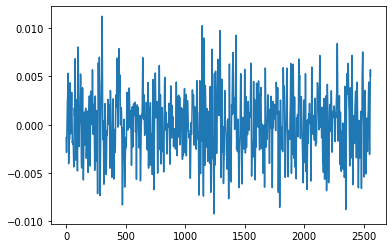

In [63]:
all_dataframe = seg_MDD + seg_H
y = y_MDD + y_H
all_dataframe[0]['Fp1-LE'].plot()
all_dataframe[0].shape

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_dataframe, y, test_size=0.2, random_state = 777)


In [65]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [66]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(1354, 2560, 4)
(1354,)
(339, 2560, 4)


In [71]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


def true_pred(model, validation_generator):
    validation_generator.reset()
    predictions = model.predict_generator(validation_generator, steps=1)
    test_preds = np.rint(predictions)
    l=test_preds.shape[0]
    test_trues = validation_generator.classes
    return test_trues, test_preds

In [72]:

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

def conv_model():
    opt = Adam(lr=0.001)
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(seg_unit,4)))
    model.add(layers.MaxPool1D(pool_size=2))
    model.add(layers.Conv1D(filters=32, kernel_size=2, activation='relu'))
    model.add(layers.MaxPool1D(pool_size=2))
    model.add(layers.Conv1D(filters=16, kernel_size=2, activation='relu'))
    model.add(layers.MaxPool1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=opt,
                    loss='binary_crossentropy',
                    metrics=['accuracy',  sensitivity, specificity])

    return model

In [73]:
model = conv_model()
history = model.fit(X_train, y_train, epochs=30, batch_size=256, verbose=1, validation_split=(0.1))
history_dict = history.history


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
5/5 [==============================] - 6s 1s/step - loss: 0.6929 - accuracy: 0.5140 - sensitivity: 0.7190 - specificity: 0.2908 - val_loss: 0.6917 - val_accuracy: 0.5294 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00
Epoch 2/30
5/5 [==============================] - 6s 1s/step - loss: 0.6927 - accuracy: 0.5140 - sensitivity: 1.0000 - specificity: 0.0000e+00 - val_loss: 0.6912 - val_accuracy: 0.5294 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00
Epoch 3/30
5/5 [==============================] - 5s 964ms/step - loss: 0.6925 - accuracy: 0.5140 - sensitivity: 1.0000 - specificity: 0.0000e+00 - val_loss: 0.6914 - val_accuracy: 0.5294 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00
Epoch 4/30
5/5 [==============================] - 5s 960ms/step - loss: 0.6921 - accuracy: 0.5140 - sensitivity: 1.0000 - specificity: 0.0000e+00 - val_loss: 0.6907 - val_accuracy: 0.5294 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00
Epoch 5/30
5/5 [==================

In [74]:
model.evaluate(X_test, y_test)

11/11 [==============================] - 0s 34ms/step - loss: 0.5285 - accuracy: 0.7139 - sensitivity: 0.5598 - specificity: 0.8582


[0.5284646153450012,
 0.7138643264770508,
 0.5597558617591858,
 0.8581674098968506]

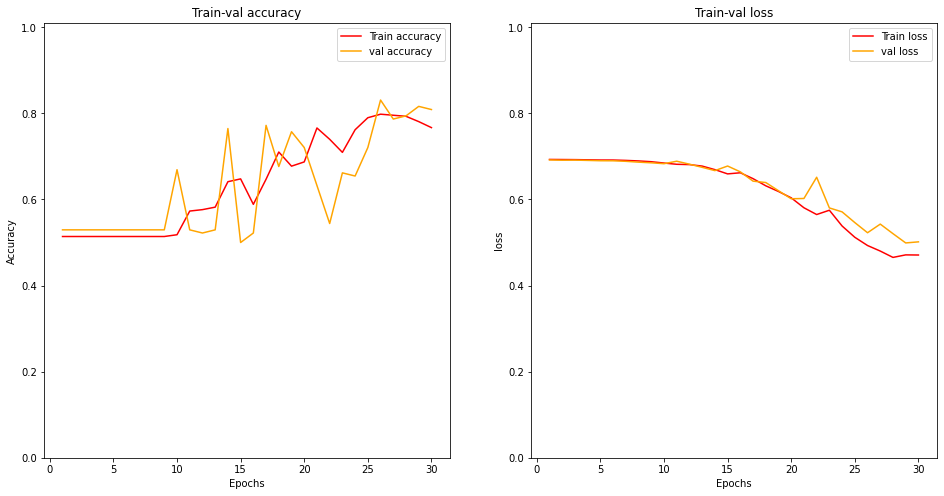

In [75]:
accuracy = history_dict['accuracy']   
val_accuracy = history_dict['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title("Train-val accuracy")
plt.plot(epochs, accuracy, 'r', label='Train accuracy')
plt.plot(epochs, val_accuracy, 'orange', label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.01)
plt.legend()

loss = history_dict['loss']   
val_loss = history_dict['val_loss']

plt.subplot(1,2,2)
epochs = range(1, len(loss) + 1)
plt.title("Train-val loss")
plt.plot(epochs, loss, 'r', label='Train loss')
plt.plot(epochs, val_loss, 'orange', label='val loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.ylim(0,1.01)
plt.legend()